# A first complete session work: Adjusting a straight line

##### In this notebook we adjust the most basic example for a two parameter model: a stright line. What we are going to do is to fit the free parameters of it, i.e. we adjust $a$ and $b$ from our model:

$y=a+bx$.  

##### We generate 3 different set of data distributed randomly around a known straight line with a gaussian noise with different standar deviation $\sigma$ for each set of data. Two of the datasets are generated with the parameters $a=3$ and $b=2$ ($\sigma=0.3$ and $\sigma =0.2$) while the last dataset is generated with the parameters $a=3.5$ and $b=1.5$ ($\sigma = 0.5$). This is done in order to show the importance of the hyperparameter procedure.

In [3]:
'''We start with the packages that we will need in our procedure'''

%pylab inline

import pymc3 as pm
from pymc3.backends import SQLite
import triangle
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/home/enriques/Downloads/yes/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### The procedure for our bayesian estimation is as follows:

##### 1.-We generate/download/import our data

##### 2.- We need to specify our model

##### 3.- With the help of PyMC3 we fit the best parameters that adjusted to our data.

##### 4.- If we have several datasets, we compare bout cases: with and without hyperparameters 

# We start by generating our 3 data sets

In [6]:
# Initialize random number generator
np.random.seed(123)

#True parameter values
a1_real = 3.
b1_real = 2.
sigma1 = 0.3
sigma2 = 0.2

a2_real = 3.5
b2_real = 1.5
sigma3 = 0.5
    
#Size of dataset
size = 16

#Generating our data

def stright(a,b,size,sigma):
    x = 3*np.random.randn(size)
    q = np.random.randn(size)*sigma
    y = a+b*x+q
    y_error = abs(q)++abs(np.random.randn(size))*0.2
    return x, y, y_error

x1, y1, y1_error = stright(a1_real,b1_real,size,sigma1)
x2, y2, y2_error = stright(a1_real,b1_real,size,sigma2)
x3, y3, y3_error = stright(a2_real,b2_real,size,sigma3)

### How our data looks like?

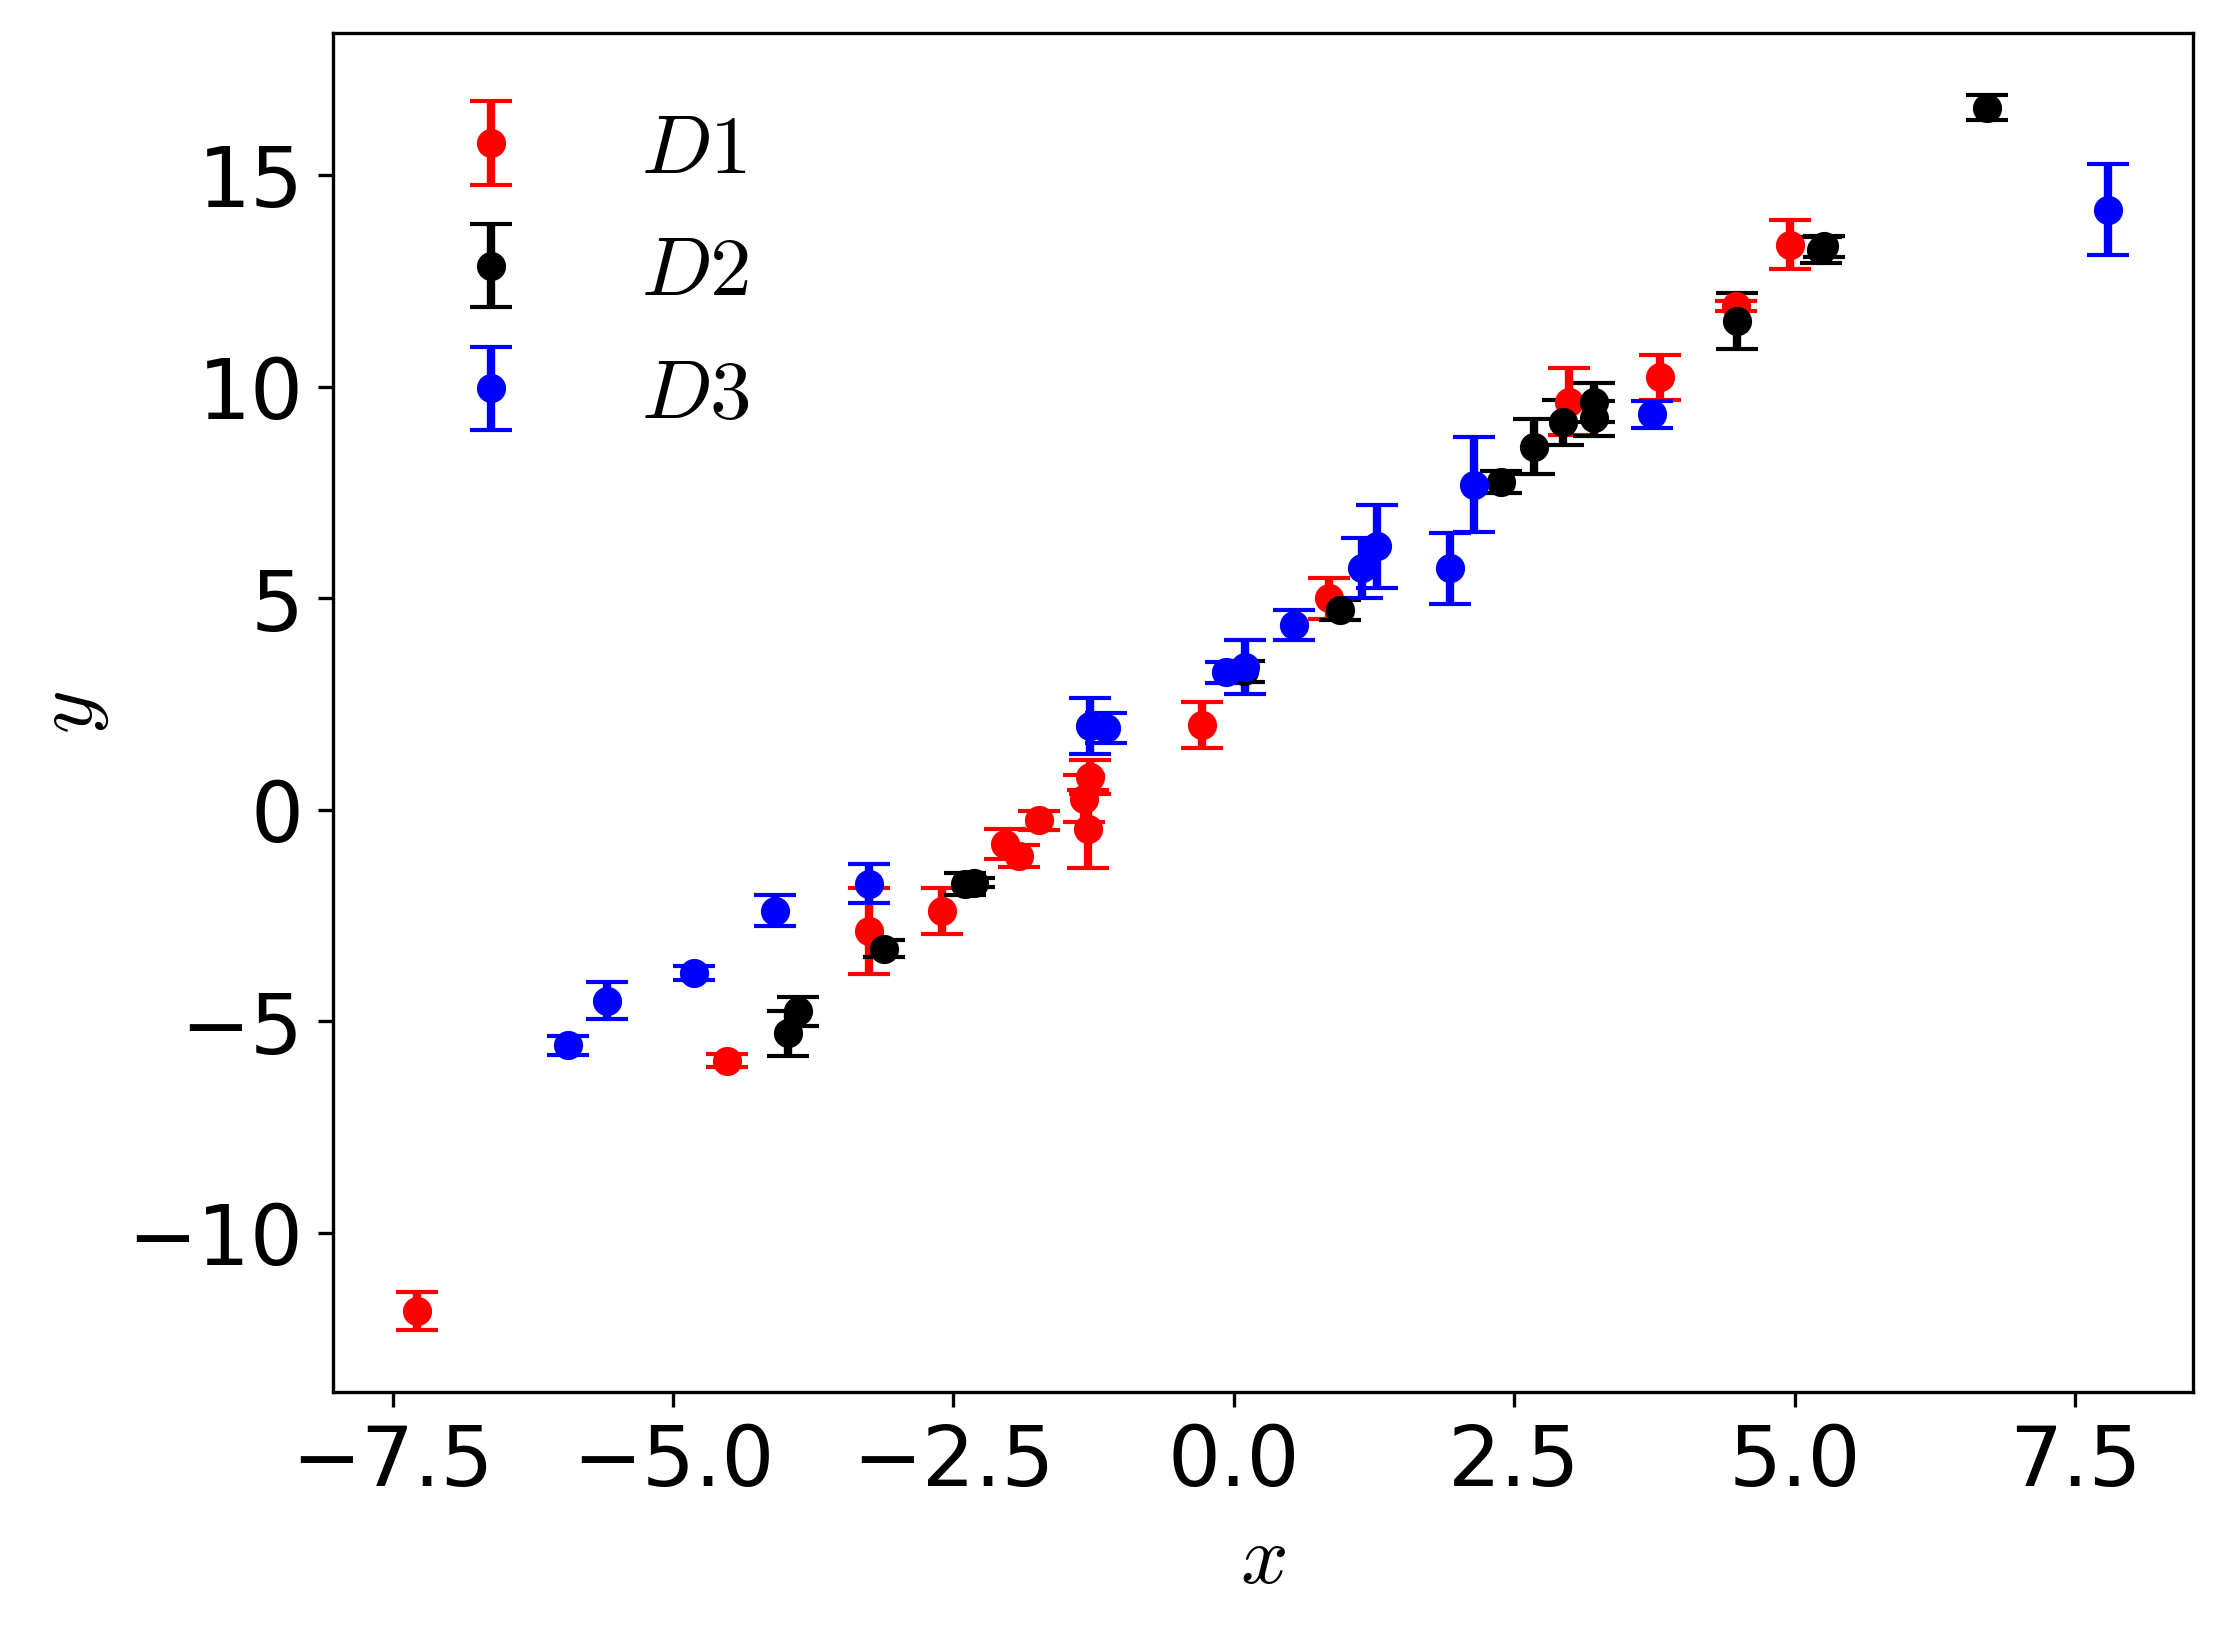

In [7]:
figsize = (8, 6)                        # definimos el tamaño de nuestra figura
dpi = 300                                # dots per inch

rcParams['font.size'] = 20          # establecemos el tamaño de la fuente
rcParams['lines.linewidth'] = 1          # el grosor de las líneas
rcParams['mathtext.fontset'] = 'cm'      # y el tipo de fuente en LaTex 

fig1 = figure(figsize=figsize, dpi=dpi)  # definimos la figura

 
plt.errorbar(x1, y1, y1_error,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='red', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$D1$')
plt.errorbar(x2, y2, y2_error,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='black', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$D2$')
plt.errorbar(x3, y3, y3_error,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='blue', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$D3$')


plt.legend(loc='best', frameon=False)     #pon la legenda donde mejor quede sin marco

xlabel(r'$x$')                            
ylabel(r'$y$')   

# Now it is time to specify our model. 

##### Suppose we are working in a theory where we would expect to have observations inside a stright line. Then we meassure our observables with 3 different mechanisms (for example: supernovae, cmb, etc.) and we obtain the datasets shown before, $\langle D_1(a=3,b=2,\sigma=0.3),D_2(a=3,b=2,\sigma=0.2), D_3(a=3.5,b=0.15,\sigma=0.5)\rangle$. 

##### Given our theory we expect that all three data are part of the same theory, i.e. the same straight line, $y=a+bx$ (remember, at this point we consider that we don't know anything about the parameters of our model, $a$ and $b$). 

###### As we saw, we can analize our system in two different ways: first is by considering a typical bayesian estimation where our data is the complete data set. In the other side, we can make the same considering a weight for each dataset, this is, by taking into account a hyperparameter method. Lets see what happen.

## *Inference of parameters without hyperparameters

##### We need to consider priors for our parameters. In this example we consider a non-informative prior, i.e. we associate uniform distribution as our priors for our parameters.

$a \sim U[-5,5]$


$b\sim U[0,4]$


##### In the other side, we consider that the set of data are independent between them, in such case the complete Likelihood can be wirten as a product of the likelihoods associated with each data set. 

$L\sim Exp\left[\sum_i-\frac{(y_t-y_i)^2}{2\sigma_i^2}\right]$



In [9]:
# Because we are interested in an inference without taking into account hyperparameters, it results the same if we
# consider the 3 datasets as one. It can be easily to see in the gaussian approximation. In this way we star adding all
# our data in one new vector called Data_x and Data_y

Data_x = np.concatenate((x1,x2),axis = 0)
Data_y = np.concatenate((y1,y2),axis = 0)
Data_y_error = np.concatenate((y1_error,y2_error),axis = 0)


#We need to define our model
with pm.Model() as model0:
    # Priors for unknown model parameters
    a0 = pm.Uniform('a0', lower=-5, upper=5)
    b0 = pm.Uniform('b0', lower=0, upper=4)
    
    y0 = a0+b0*Data_x
    
    Lik0 = pm.Normal('Lik0',mu=y0,sd=Data_y_error,observed=Data_y)   

In [10]:
#We specify the number of iterations
niter0=10000
with model0:
    start0 = pm.find_MAP() #Compute a maximum a posteriori estimates 
    step0 = pm.Metropolis()
    db0 = SQLite('H0_2_Data_1.db')
    trace0 = pm.sample(niter0, trace=db0, step=step0, njobs=6, temp = 2, thin=50, cores=4,random_seed=123)

logp = -1,945.8, ||grad|| = 3,254.9: 100%|██████████| 9/9 [00:00<00:00, 1343.28it/s]
Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [b0_interval__]
>Metropolis: [a0_interval__]
  0%|          | 0/10500 [00:00<?, ?it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 32%|███▏      | 3312/10500 [00:02<00:04, 1512.88it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 49%|████▉     | 5158/10500 [00:04<00:04, 1220.76it/s]/home/enriques

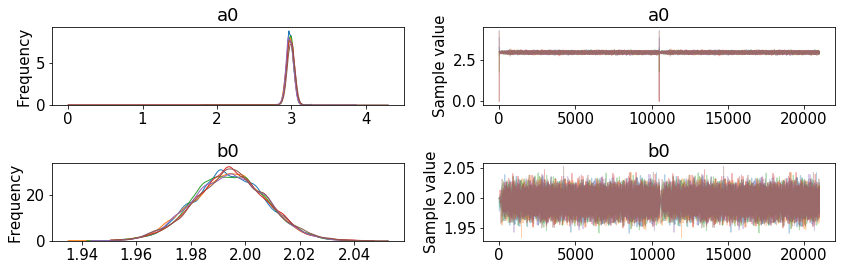

In [11]:
rcParams['font.size'] = 15

with model0:
    tracee = pm.backends.sqlite.load('H0_2_Data_1.db')
    pm.traceplot(tracee, varnames=['a0','b0'])

In [12]:
t0 = trace0[niter0//2:]
t0['a0'].shape
t0['b0'].shape

(90000,)

In [13]:
a0 = trace0.get_values('a0', burn=niter0//2, combine=True, chains=[0,2])
a0.shape

b0 = trace0.get_values('b0', burn=niter0//2, combine=True, chains=[0,2])
b0.shape

(30000,)

In [15]:
pm.gelman_rubin(t0)

{'a0': 1.0001302013362403, 'b0': 1.0002972338767406}

In [16]:
pm.summary(t0, varnames=['a0','b0'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a0,2.982247,0.047964,0.000232,2.889695,3.076446,31348.0,1.000130
b0,1.994275,0.013440,0.000072,1.967680,2.020226,31666.0,1.000297


/home/enriques/Downloads/yes/lib/python2.7/site-packages/matplotlib/contour.py:920: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


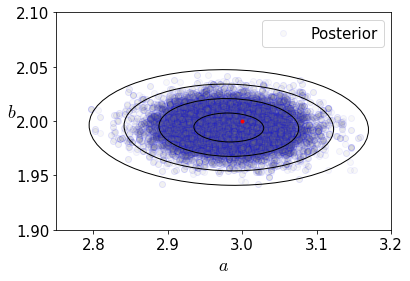

In [17]:
from matplotlib.patches import Ellipse

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

ax = plt.subplot(111)
for nstd in range (1,5):
    cov = np.cov(a0, b0)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(a0), np.mean(b0)),
                  width=w, height=h,
                  angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

plot(a0, b0,
     linestyle='none', marker='o', color='grey', mec='blue',
alpha=.05, label='Posterior', zorder=-100)

import scipy.stats
gkde = scipy.stats.gaussian_kde([a0, b0])
x,y = mgrid[0.:1.:5., 0.:100.:4.]
z = array(gkde.evaluate([x.flatten(),y.flatten()])).reshape(x.shape)
contourf(x, y, z,4, linewidths=1, alpha=.5, cmap='Greys')
plt.plot([3], [2], marker='o', markersize=3, color="red")
ylabel(r'$b$', fontsize=18, rotation=0)
xlabel(r'$a$', fontsize=18)
legend()
axis([ 2.75, 3.2,1.9, 2.1])
savefig('parm_dist.png')

## *Inference of parameters with hyperparameters

##### Now we consider the Likelihood

$L=\prod_{k=1}^N\frac{2\Gamma(\frac{n_k}{2}+1)}{\pi^{n_k/2}|V_k|^{1/2}}(\chi_k^2+2)^{-\left(\frac{n_k}{2}+1\right)}
$

In [18]:
import theano.tensor as T
import theano as TT
from theano.tensor import _shared

def ymodel(a,b,x):
    return a+b*x
    
def sigma_inv(sigma):
    return np.diag(1/sigma)

def chi2(a,b,x,data,sigma,n):
    D = ymodel(a,b,x)-data
    sigma2_mat_inv = _shared(sigma_inv(sigma)**2)
    return T.dot(D,T.dot(sigma2_mat_inv,D))/2

def log_Like1D(a,b,x,y,sigma,n):
    N = 1*n/2+1.
    extr = 2*np.linalg.det(sigma_inv(sigma))/(math.pi**(n/2))
    return T.gammaln(N)-N*T.log(chi2(a,b,x,y,sigma,n)+2)+T.log(extr)

with pm.Model() as model1:
    # Priors for unknown model parameters
    a = pm.Uniform('a', lower=-5., upper=8.)
    b = pm.Uniform('b', lower=0., upper=4.)
    
    Lik = pm.Potential('Lik',log_Like1D(a,b,x1,y1,y1_error,size)+log_Like1D(a,b,x2,y2,y2_error,size))

In [19]:
niter=10000
with model1:
    start = pm.find_MAP() #Compute a maximum a posteriori estimates 
    step = pm.Metropolis()
    db = SQLite('H1_2_Data_1.db')
    trace = pm.sample(niter, trace=db, step=step,njobs=5,temp = 2,thin=50,cores = 4, random_seed=123)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
logp = 2.7871, ||grad|| = 9.8156e-05: 100%|██████████| 12/12 [00:00<00:00, 263.46it/s]  
Multiprocess sampling (5 chains in 5 jobs)
CompoundStep
>Metropolis: [b_interval__]
>Metropolis: [a_interval__]
  0%|          | 0/10500 [00:00<?, ?it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 34%|███▍      | 3594/10500 [00:02<00:05, 1306.01it/s]/home/enriques/Downloads/

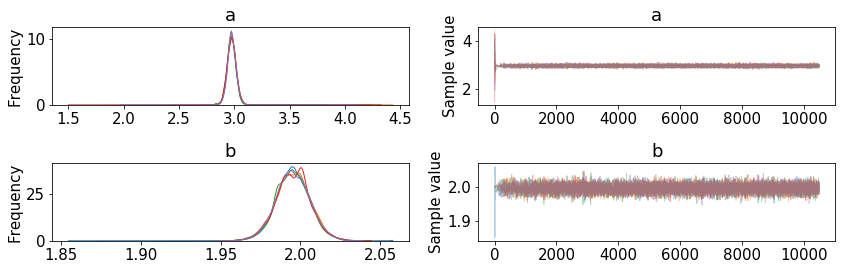

In [20]:
with model1:
    tracee = pm.backends.sqlite.load('H1_2_Data_1.db')
    pm.traceplot(tracee, varnames=['a','b'])

In [21]:
t = trace[niter//2:]
t['a'].shape
t['b'].shape

(25000,)

In [22]:
a = trace.get_values('a', burn=niter//2, combine=True, chains=[0,2])
a.shape

b = trace.get_values('b', burn=niter//2, combine=True, chains=[0,2])
b.shape

(10000,)

In [23]:
pm.gelman_rubin(t)

{'a': 1.00022927541981, 'b': 1.0000439461307}

In [24]:
pm.summary(t, varnames=['a','b'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,2.974059,0.038583,0.000362,2.897585,3.049008,9675.0,1.000229
b,1.995189,0.010611,0.000118,1.974255,2.015879,9857.0,1.000044


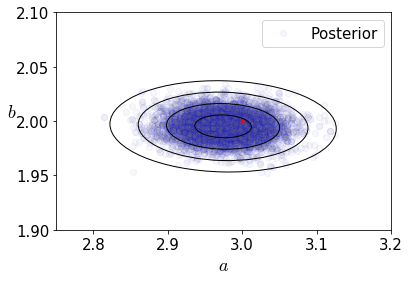

In [25]:
from matplotlib.patches import Ellipse

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

ax = plt.subplot(111)
for nstd in range (1,5):
    cov = np.cov(a, b)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(a), np.mean(b)),
                  width=w, height=h,
                  angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

plot(a, b,
     linestyle='none', marker='o', color='grey', mec='blue',
alpha=.05, label='Posterior', zorder=-100)

import scipy.stats
gkde = scipy.stats.gaussian_kde([a, b])
x,y = mgrid[0.:1.:5., 0.:100.:4.]
z = array(gkde.evaluate([x.flatten(),y.flatten()])).reshape(x.shape)
contourf(x, y, z,4, linewidths=1, alpha=.5, cmap='Greys')
plt.plot([3], [2], marker='o', markersize=3, color="red")
ylabel(r'$b$', fontsize=18, rotation=0)
xlabel(r'$a$', fontsize=18)
legend()
axis([ 2.75, 3.2,1.9, 2.1])
savefig('parm_dist.png')

# But, what method is better?

##### PyMC contains a way to estimate the Bayes factor using the Sequential Monte Carlo method. So, let us recalculate our posterior using this method

In [27]:
#We specify the number of iterations
from tempfile import mkdtemp
from pymc3.step_methods import smc 
niter0=10000
folder = mkdtemp(prefix='strightline')
with model0:
    trace0_nm = smc.sample_smc(niter0,n_chains = 5,homepath = folder,progressbar=False,stage = 0,random_seed=123)
    
with model1:
    trace1_nm = smc.sample_smc(niter0,n_chains = 5,homepath = folder,progressbar=False,stage = 0,random_seed=123)

/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/step_methods/smc.py:491: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Argument `step` is None. Auto-initialising step object using given/default parameters.
/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/step_methods/smc.py:119: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Adding model likelihood to RVs!
Init new trace!
Sample initial stage: ...
Beta: 0.000000 Stage: 0
Initialising chain traces ...
Sampling ...
Beta: 0.000560 Stage: 1
Initialising chain traces ...
Sampling ...
Beta: 0.010141 Stage: 2
Initialising chain traces ...
Sampling ...
Beta: 0.036751 Stage: 3
Initialising chain traces ...
Sampling ...
Beta: 0.094140 Stage: 4
Initialising chain traces ...
Sampling ...
Beta: 0.448289 Stage: 5
Initialising chain traces ..

In [28]:
#Computing the Bayes factor
BF = model1.marginal_likelihood / model0.marginal_likelihood
print(round(BF))

3.0


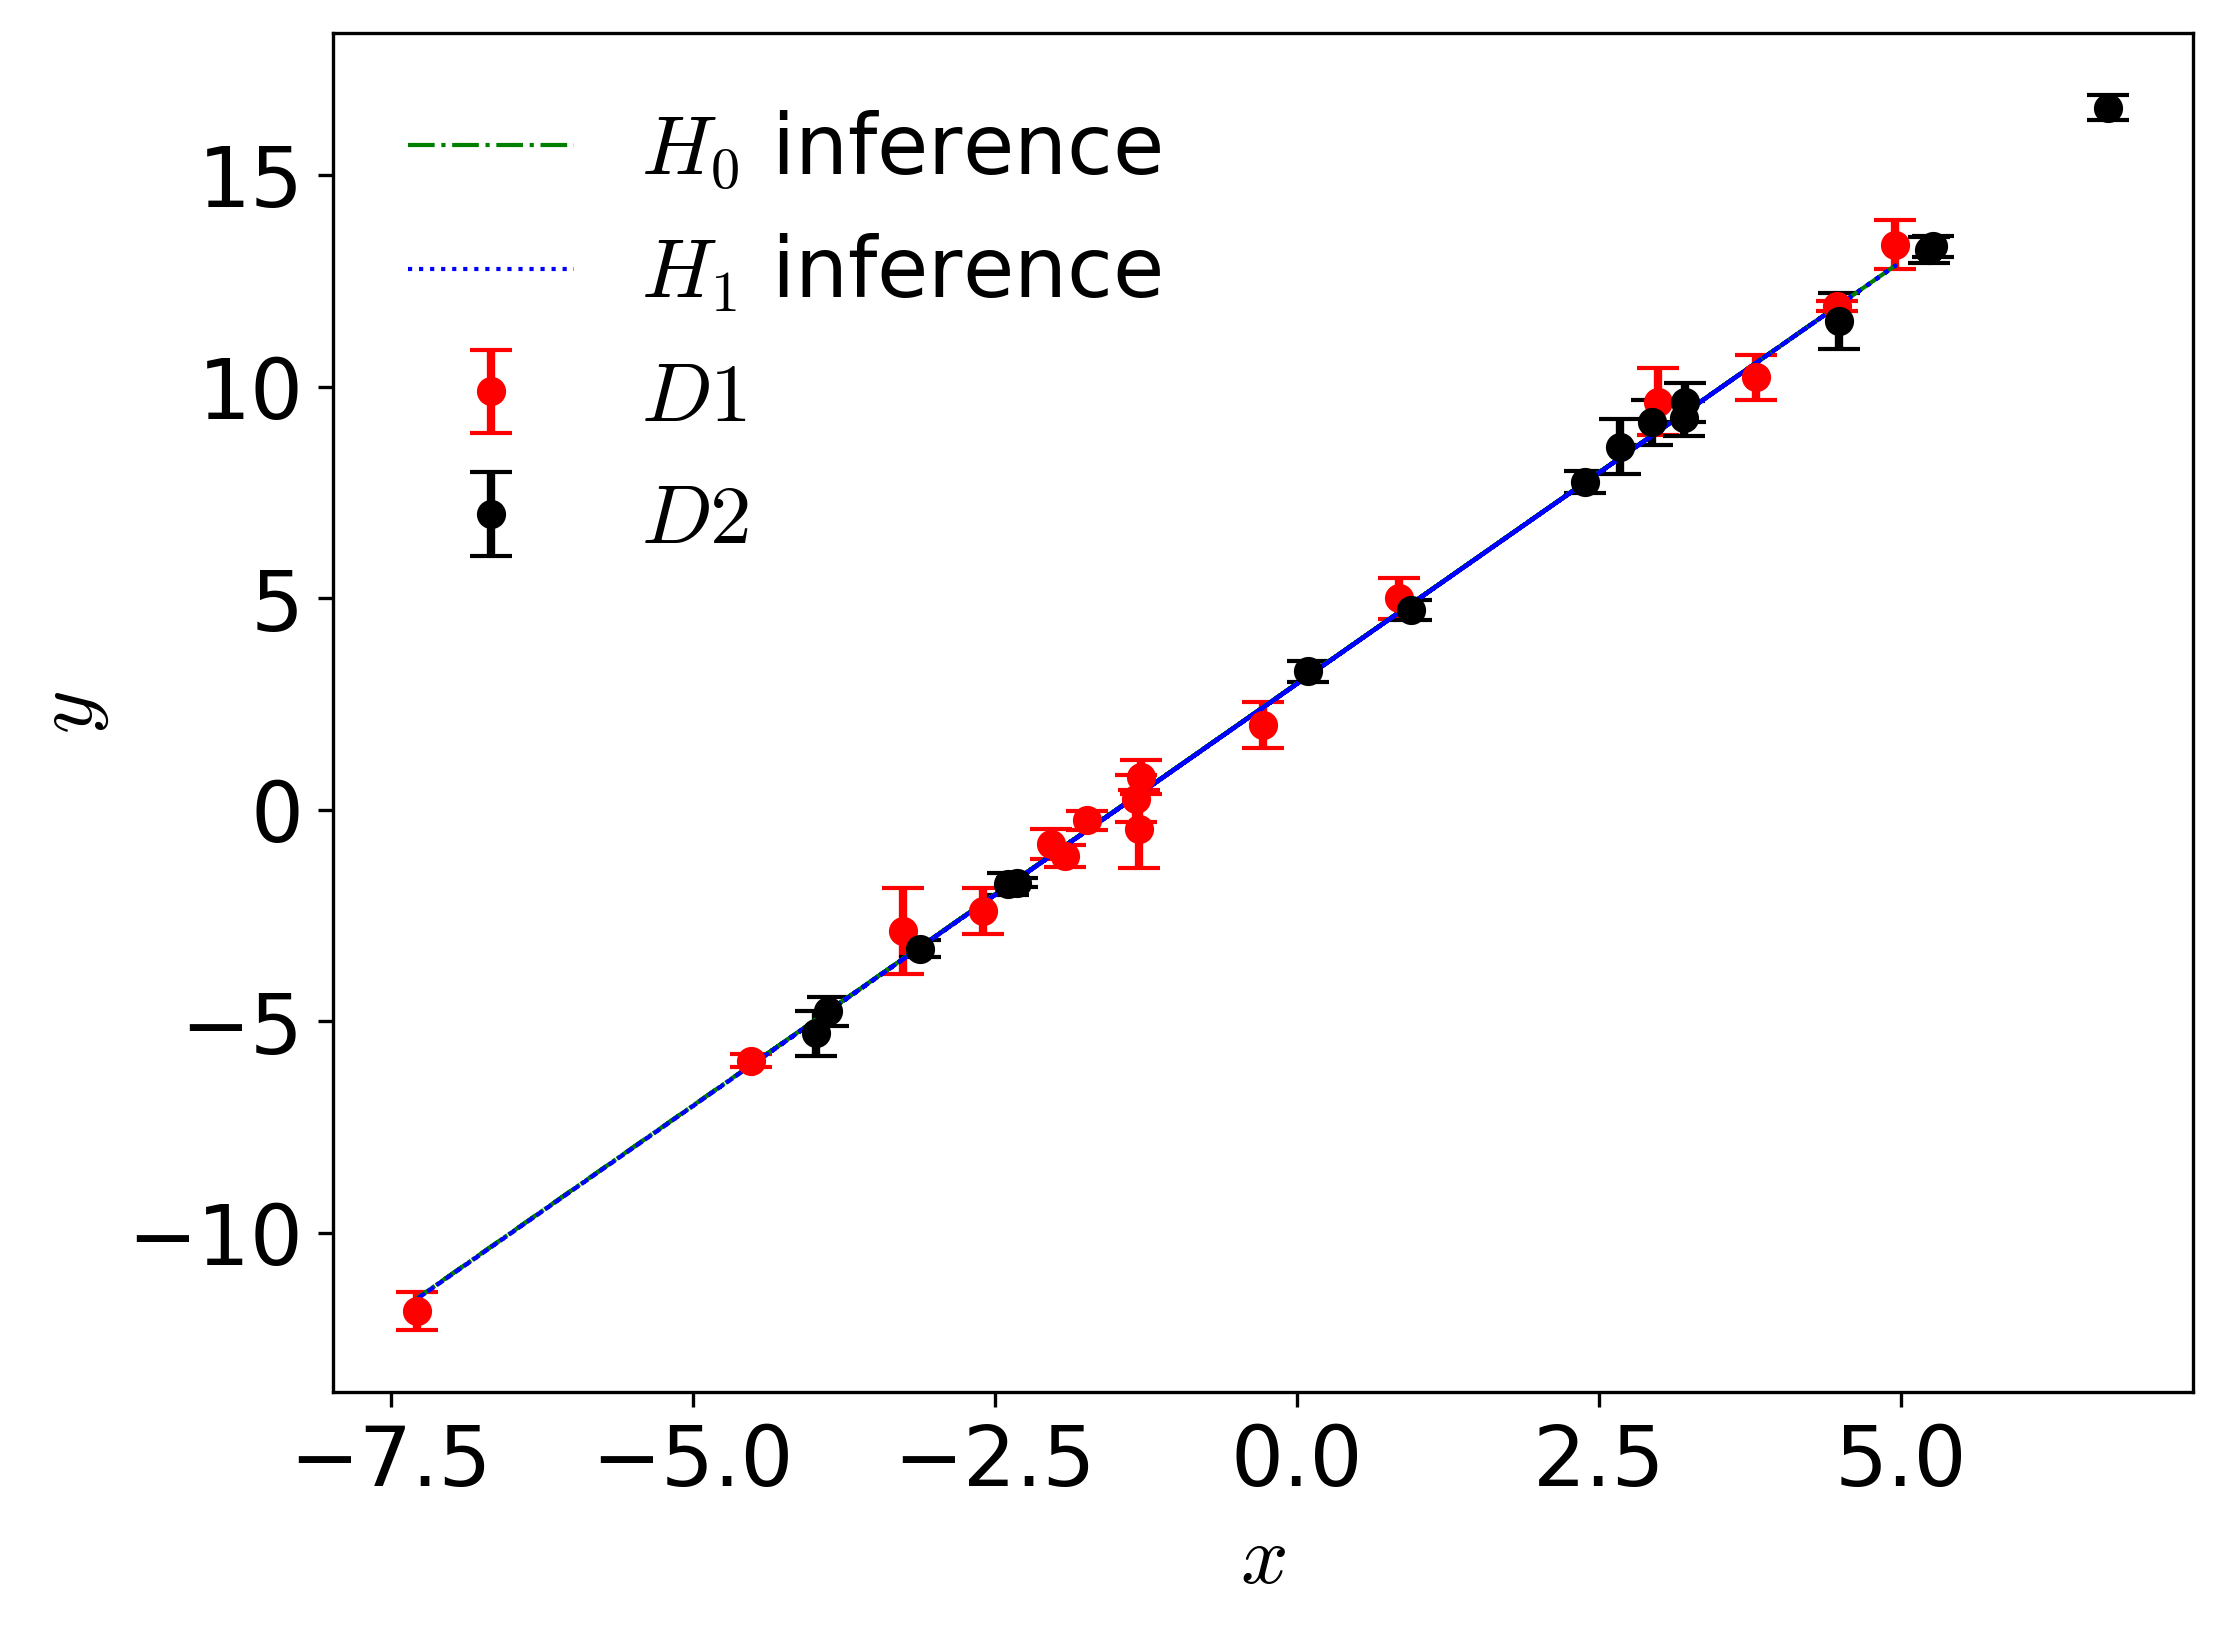

In [29]:
figsize = (8, 6)                        # definimos el tamaño de nuestra figura
dpi = 300                                # dots per inch

rcParams['font.size'] = 20          # establecemos el tamaño de la fuente
rcParams['lines.linewidth'] = 1          # el grosor de las líneas
rcParams['mathtext.fontset'] = 'cm'      # y el tipo de fuente en LaTex 

fig1 = figure(figsize=figsize, dpi=dpi)  # definimos la figura

 
plt.errorbar(x1, y1, y1_error,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='red', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$D1$')
plt.errorbar(x2, y2, y2_error,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='black', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$D2$')

plt.plot(x1,2.982407+1.994251*x1,label = '$H_0$ inference',color = 'green', linestyle='-.')
plt.plot(x1,2.974059+1.995189*x1,label = '$H_1$ inference',linestyle=':', color = 'blue')

plt.legend(loc='best', frameon=False)     #pon la legenda donde mejor quede sin marco

xlabel(r'$x$')                            
ylabel(r'$y$')  

# Case 2

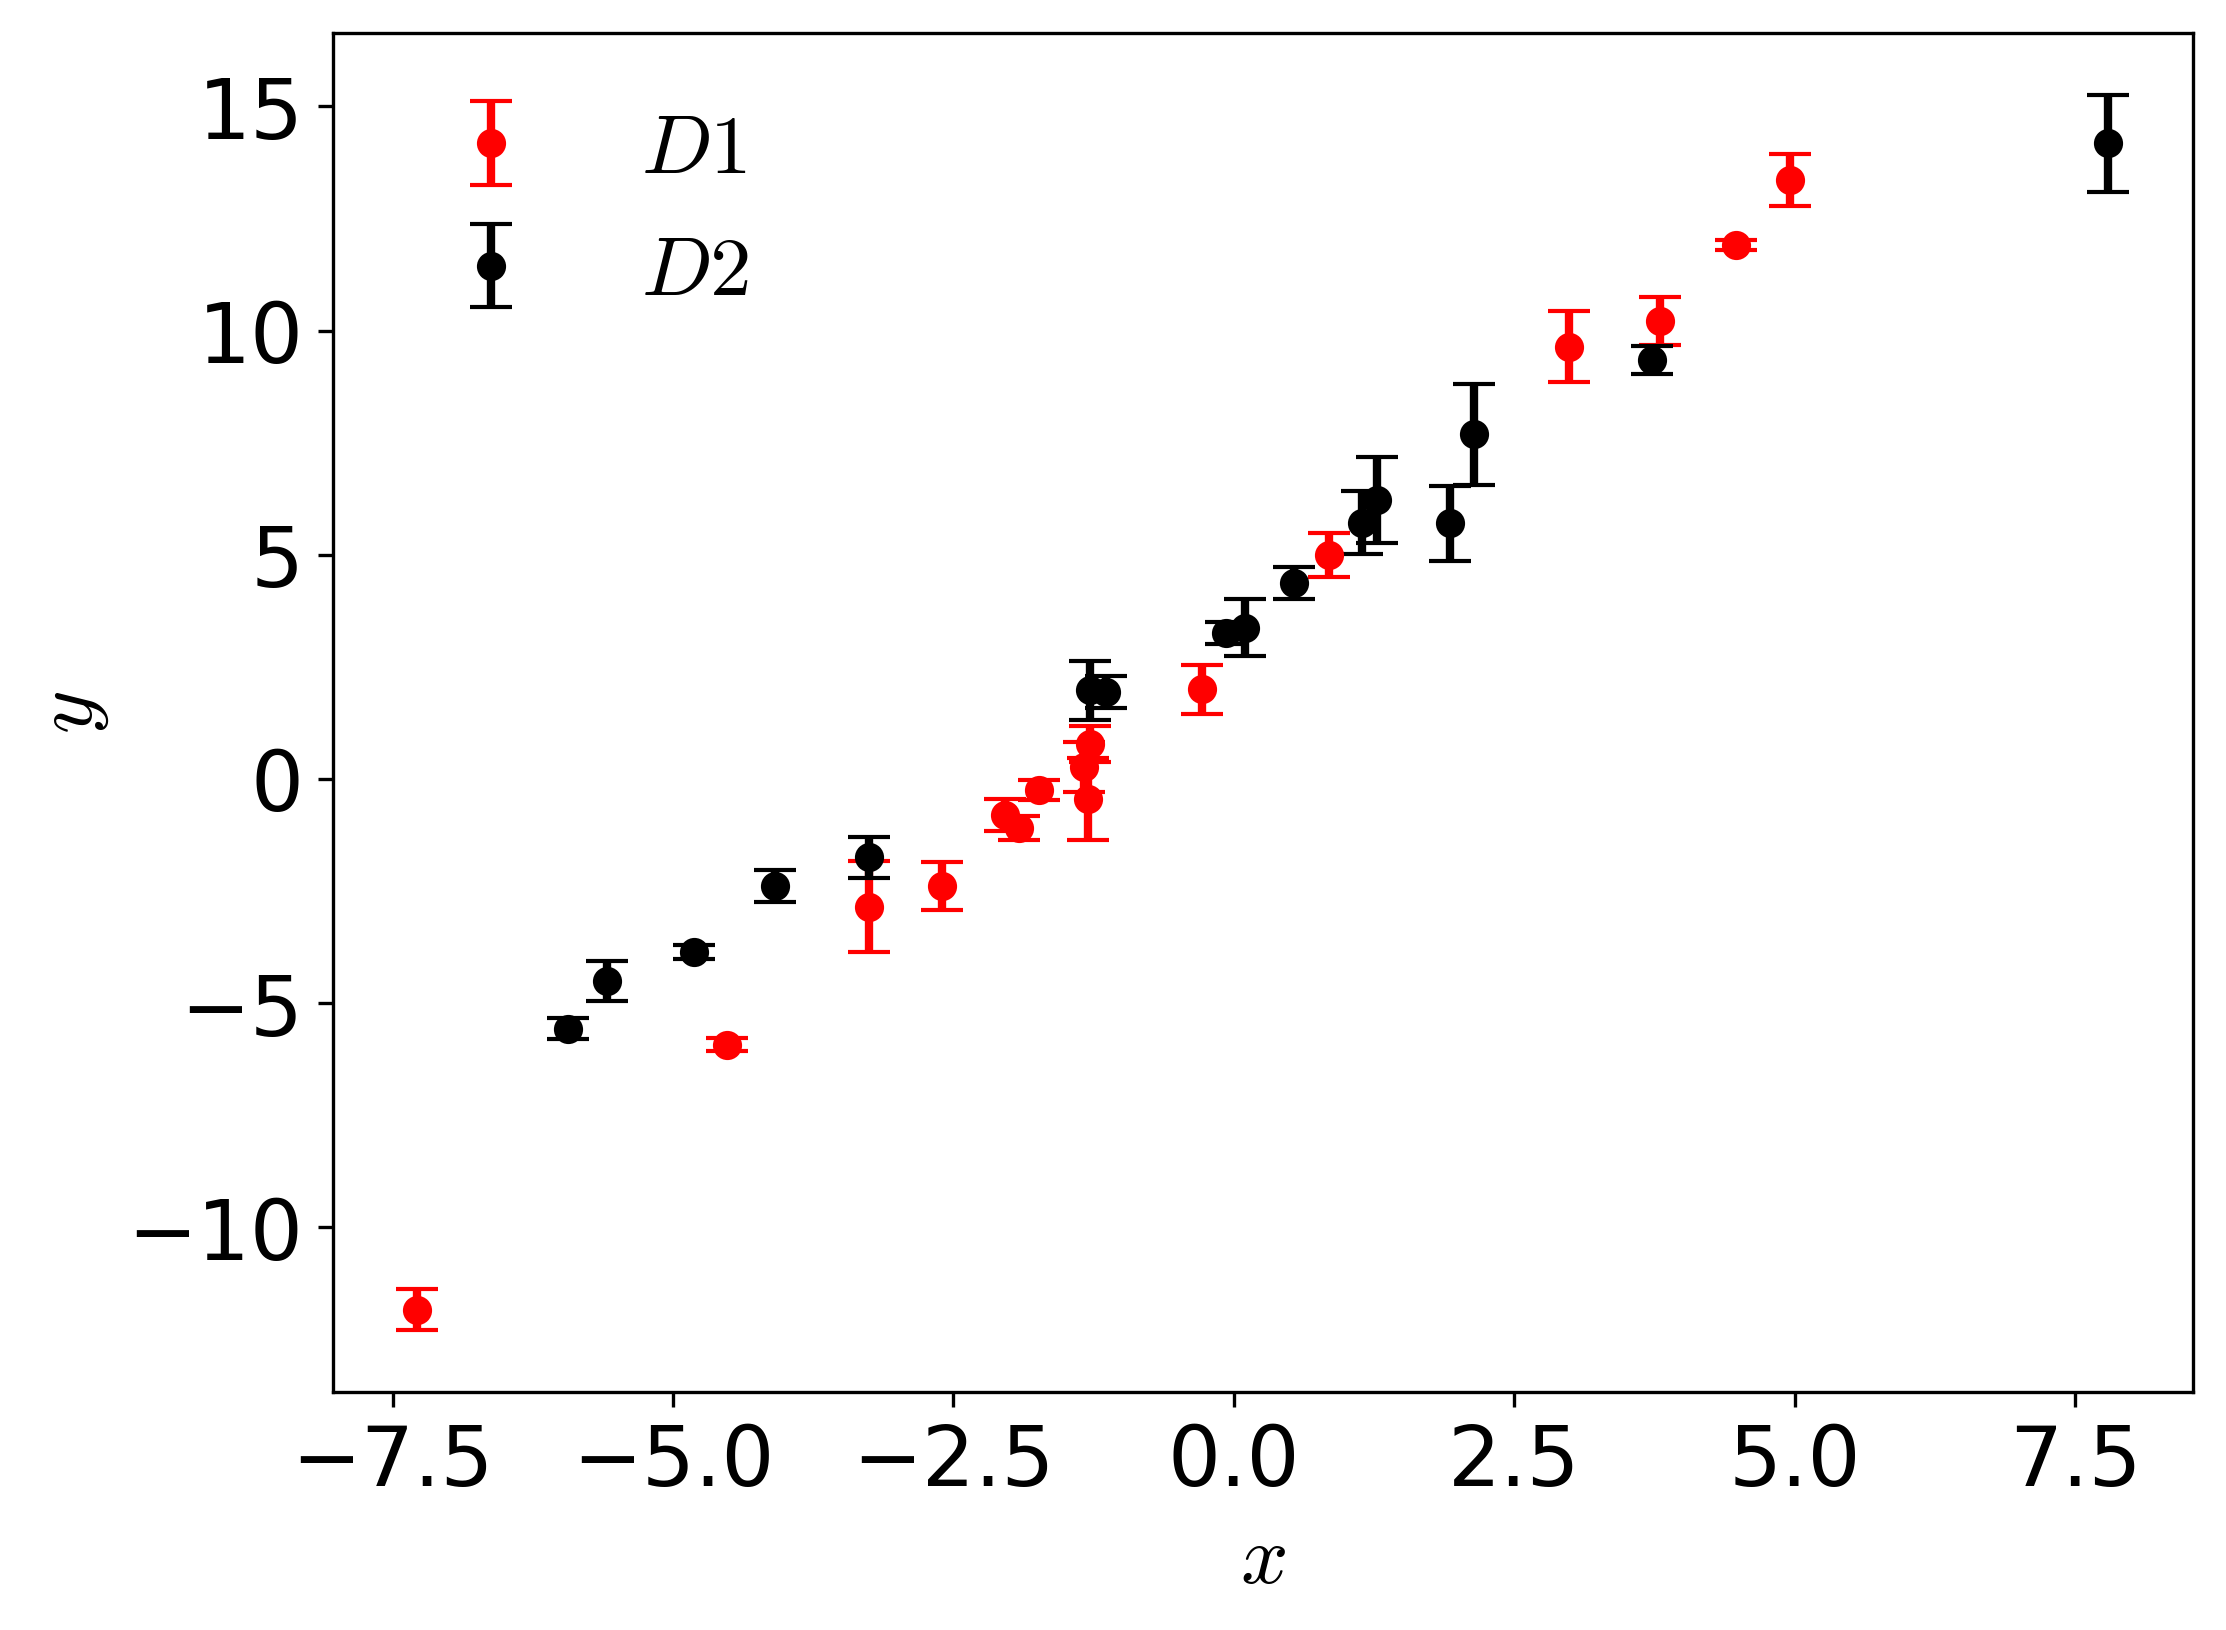

In [30]:
figsize = (8, 6)                        # definimos el tamaño de nuestra figura
dpi = 300                                # dots per inch

rcParams['font.size'] = 20          # establecemos el tamaño de la fuente
rcParams['lines.linewidth'] = 1          # el grosor de las líneas
rcParams['mathtext.fontset'] = 'cm'      # y el tipo de fuente en LaTex 

fig1 = figure(figsize=figsize, dpi=dpi)  # definimos la figura

 
plt.errorbar(x1, y1, y1_error,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='red', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$D1$')
plt.errorbar(x3, y3, y3_error,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='black', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$D2$')


plt.legend(loc='best', frameon=False)     #pon la legenda donde mejor quede sin marco

xlabel(r'$x$')                            
ylabel(r'$y$') 

# Without hyperparameters

In [31]:
# Because we are interested in an inference without taking into account hyperparameters, it results the same if we
# consider the 3 datasets as one. It can be easily to see in the gaussian approximation. In this way we star adding all
# our data in one new vector called Data_x and Data_y

Data_x = np.concatenate((x1,x3),axis = 0)
Data_y = np.concatenate((y1,y3),axis = 0)
Data_y_error = np.concatenate((y1_error,y3_error),axis = 0)

with pm.Model() as model0_2:
    # Priors for unknown model parameters
    a0 = pm.Uniform('a0_2', lower=-5, upper=5)
    b0 = pm.Uniform('b0_2', lower=0, upper=4)
    
    y0 = a0+b0*Data_x
    
    Lik0 = pm.Normal('Lik0_2',mu=y0,sd=Data_y_error,observed=Data_y)   

In [32]:
#We specify the number of iterations
niter0=10000
with model0_2:
    start0_2 = pm.find_MAP() #Compute a maximum a posteriori estimates 
    step0 = pm.Metropolis()
    db0 = SQLite('H0_2_Data_2.db')
    trace0 = pm.sample(niter0, trace=db0, step=step0, njobs=6, temp = 2, thin=50, cores=4,random_seed=123)

logp = -2,543.2, ||grad|| = 3,661.2: 100%|██████████| 11/11 [00:00<00:00, 2545.65it/s]
Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [b0_2_interval__]
>Metropolis: [a0_2_interval__]
  0%|          | 0/10500 [00:00<?, ?it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 23%|██▎       | 2432/10500 [00:02<00:09, 814.18it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 50%|█████     | 5299/10500 [00:06<00:06, 791.24it/s]/home/enri

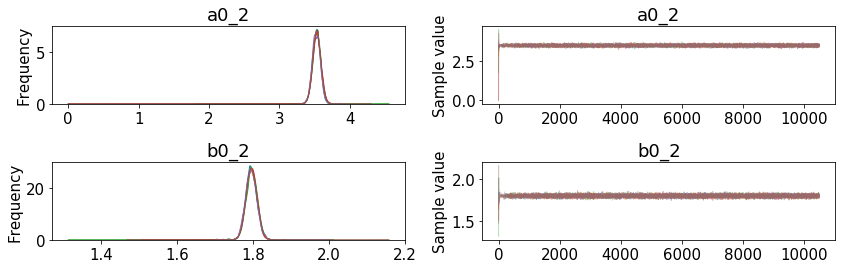

In [33]:
rcParams['font.size'] = 15

with model0_2:
    tracee = pm.backends.sqlite.load('H0_2_Data_2.db')
    pm.traceplot(tracee, varnames=['a0_2','b0_2'])

In [34]:
t0_2 = trace0[niter0//2:]
t0_2['a0_2'].shape
t0_2['b0_2'].shape

(30000,)

In [35]:
a0_2 = trace0.get_values('a0_2', burn=niter0//2, combine=True, chains=[0,2])
a0_2.shape

b0_2 = trace0.get_values('b0_2', burn=niter0//2, combine=True, chains=[0,2])
b0_2.shape

(10000,)

In [36]:
pm.gelman_rubin(t0_2)

{'a0_2': 1.0001531159573476, 'b0_2': 1.0003934053523331}

In [37]:
pm.summary(t0_2, varnames=['a0_2','b0_2'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a0_2,3.528359,0.056511,0.000524,3.421182,3.643285,10404.0,1.000153
b0_2,1.795464,0.014116,0.000141,1.767829,1.823143,10538.0,1.000393


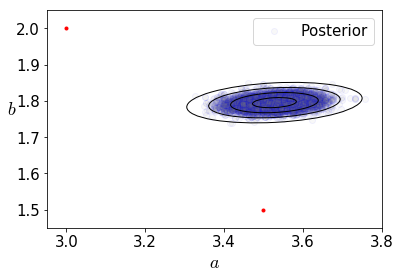

In [38]:
from matplotlib.patches import Ellipse

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

ax = plt.subplot(111)
for nstd in range (1,5):
    cov = np.cov(a0_2, b0_2)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(a0_2), np.mean(b0_2)),
                  width=w, height=h,
                  angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

plot(a0_2, b0_2,
     linestyle='none', marker='o', color='grey', mec='blue',
alpha=.05, label='Posterior', zorder=-100)

import scipy.stats
gkde = scipy.stats.gaussian_kde([a0_2, b0_2])
x,y = mgrid[0.:1.:5., 0.:100.:4.]
z = array(gkde.evaluate([x.flatten(),y.flatten()])).reshape(x.shape)
contourf(x, y, z,4, linewidths=1, alpha=.5, cmap='Greys')
plt.plot([3], [2], marker='o', markersize=3, color="red")
plt.plot([3.5], [1.5], marker='o', markersize=3, color="red")
ylabel(r'$b$', fontsize=18, rotation=0)
xlabel(r'$a$', fontsize=18)
legend()
axis([ 2.95, 3.8,1.45, 2.05])
savefig('parm_dist.png')

# With hyperparameters

In [39]:
with pm.Model() as model1_2:
    # Priors for unknown model parameters
    a = pm.Uniform('a_2', lower=-5., upper=8.)
    b = pm.Uniform('b_2', lower=0., upper=4.)
    
    Lik = pm.Potential('Lik_2',log_Like1D(a,b,x1,y1,y1_error,size)+log_Like1D(a,b,x3,y3,y3_error,size))

In [40]:
niter=10000
with model1_2:
    start_2 = pm.find_MAP() #Compute a maximum a posteriori estimates 
    step = pm.Metropolis()
    db = SQLite('H1_2_Data_2.db')
    trace = pm.sample(niter, trace=db, step=step,njobs=6,temp = 2,thin=50,cores = 4, random_seed=123)

logp = -43.026, ||grad|| = 0.00046563: 100%|██████████| 22/22 [00:00<00:00, 1076.43it/s]  
Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [b_2_interval__]
>Metropolis: [a_2_interval__]
  0%|          | 0/10500 [00:00<?, ?it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 30%|██▉       | 3126/10500 [00:03<00:07, 1008.94it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 65%|██████▌   | 6872/10500 [00:06<00:03, 1050.82it/s]/home/

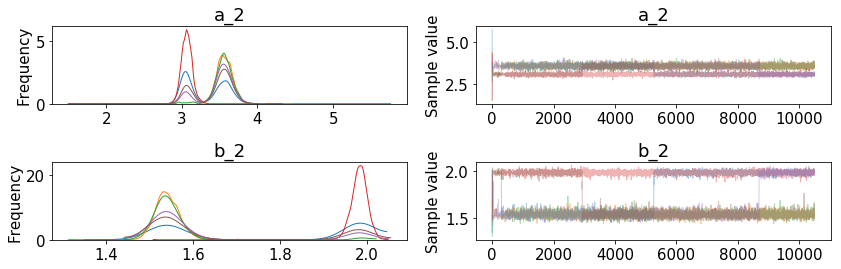

In [41]:
with model1_2:
    tracee = pm.backends.sqlite.load('H1_2_Data_2.db')
    pm.traceplot(tracee, varnames=['a_2','b_2'])

In [42]:
t_2 = trace[niter//2:]
t_2['a_2'].shape
t_2['b_2'].shape

(30000,)

In [43]:
a_2 = trace.get_values('a_2', burn=niter0//2, combine=True, chains=[0,2])
a_2.shape

b_2 = trace.get_values('b_2', burn=niter0//2, combine=True, chains=[0,2])
b_2.shape

(10000,)

[2.7, 4.0, 1.45, 2.2]

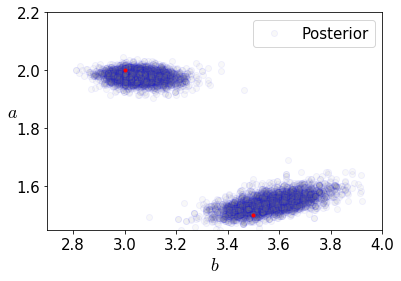

In [46]:
plot(a_2, b_2,
     linestyle='none', marker='o', color='grey', mec='blue',
alpha=.05, label='Posterior', zorder=-100)

import scipy.stats
gkde = scipy.stats.gaussian_kde([a_2, b_2])
x,y = mgrid[0.:1.:5., 0.:100.:4.]
z = array(gkde.evaluate([x.flatten(),y.flatten()])).reshape(x.shape)
contourf(x, y, z,4, linewidths=1, alpha=.5, cmap='Greys')
plt.plot([3], [2], marker='o', markersize=3, color="red")
plt.plot([3.5], [1.5], marker='o', markersize=3, color="red")


ylabel(r'$a$', fontsize=18, rotation=0)
xlabel(r'$b$', fontsize=18)
legend()
axis([ 2.7, 4.,1.45, 2.2])

In [47]:
#We specify the number of iterations
niter=10000
folder = mkdtemp(prefix='strightline')
with model0_2:
    trace0_nm = smc.sample_smc(niter,n_chains = 5,homepath = folder,progressbar=False,stage = 0,random_seed=123)
    
with model1_2:
    trace1_nm = smc.sample_smc(niter,n_chains = 5,homepath = folder,progressbar=False,stage = 0,random_seed=123)

Argument `step` is None. Auto-initialising step object using given/default parameters.
Adding model likelihood to RVs!
Init new trace!
Sample initial stage: ...
Beta: 0.000000 Stage: 0
Initialising chain traces ...
Sampling ...
Beta: 0.000518 Stage: 1
Initialising chain traces ...
Sampling ...
Beta: 0.004842 Stage: 2
Initialising chain traces ...
Sampling ...
Beta: 0.009211 Stage: 3
Initialising chain traces ...
Sampling ...
Beta: 0.014733 Stage: 4
Initialising chain traces ...
Sampling ...
Beta: 0.024276 Stage: 5
Initialising chain traces ...
Sampling ...
Beta: 0.258617 Stage: 6
Initialising chain traces ...
Sampling ...
Beta: 0.649365 Stage: 7
Initialising chain traces ...
Sampling ...
Beta > 1.: 1.460256
Sample final stage
Initialising chain traces ...
Sampling ...
Argument `step` is None. Auto-initialising step object using given/default parameters.
Adding model likelihood to RVs!
Removing previous sampling results ... /tmp/strightline03SnIR/stage_0
Init new trace!
Sample initial s

In [48]:
#Computing the Bayes factor
BF_2 = model1_2.marginal_likelihood / model0_2.marginal_likelihood
print(round(BF_2))

37.0


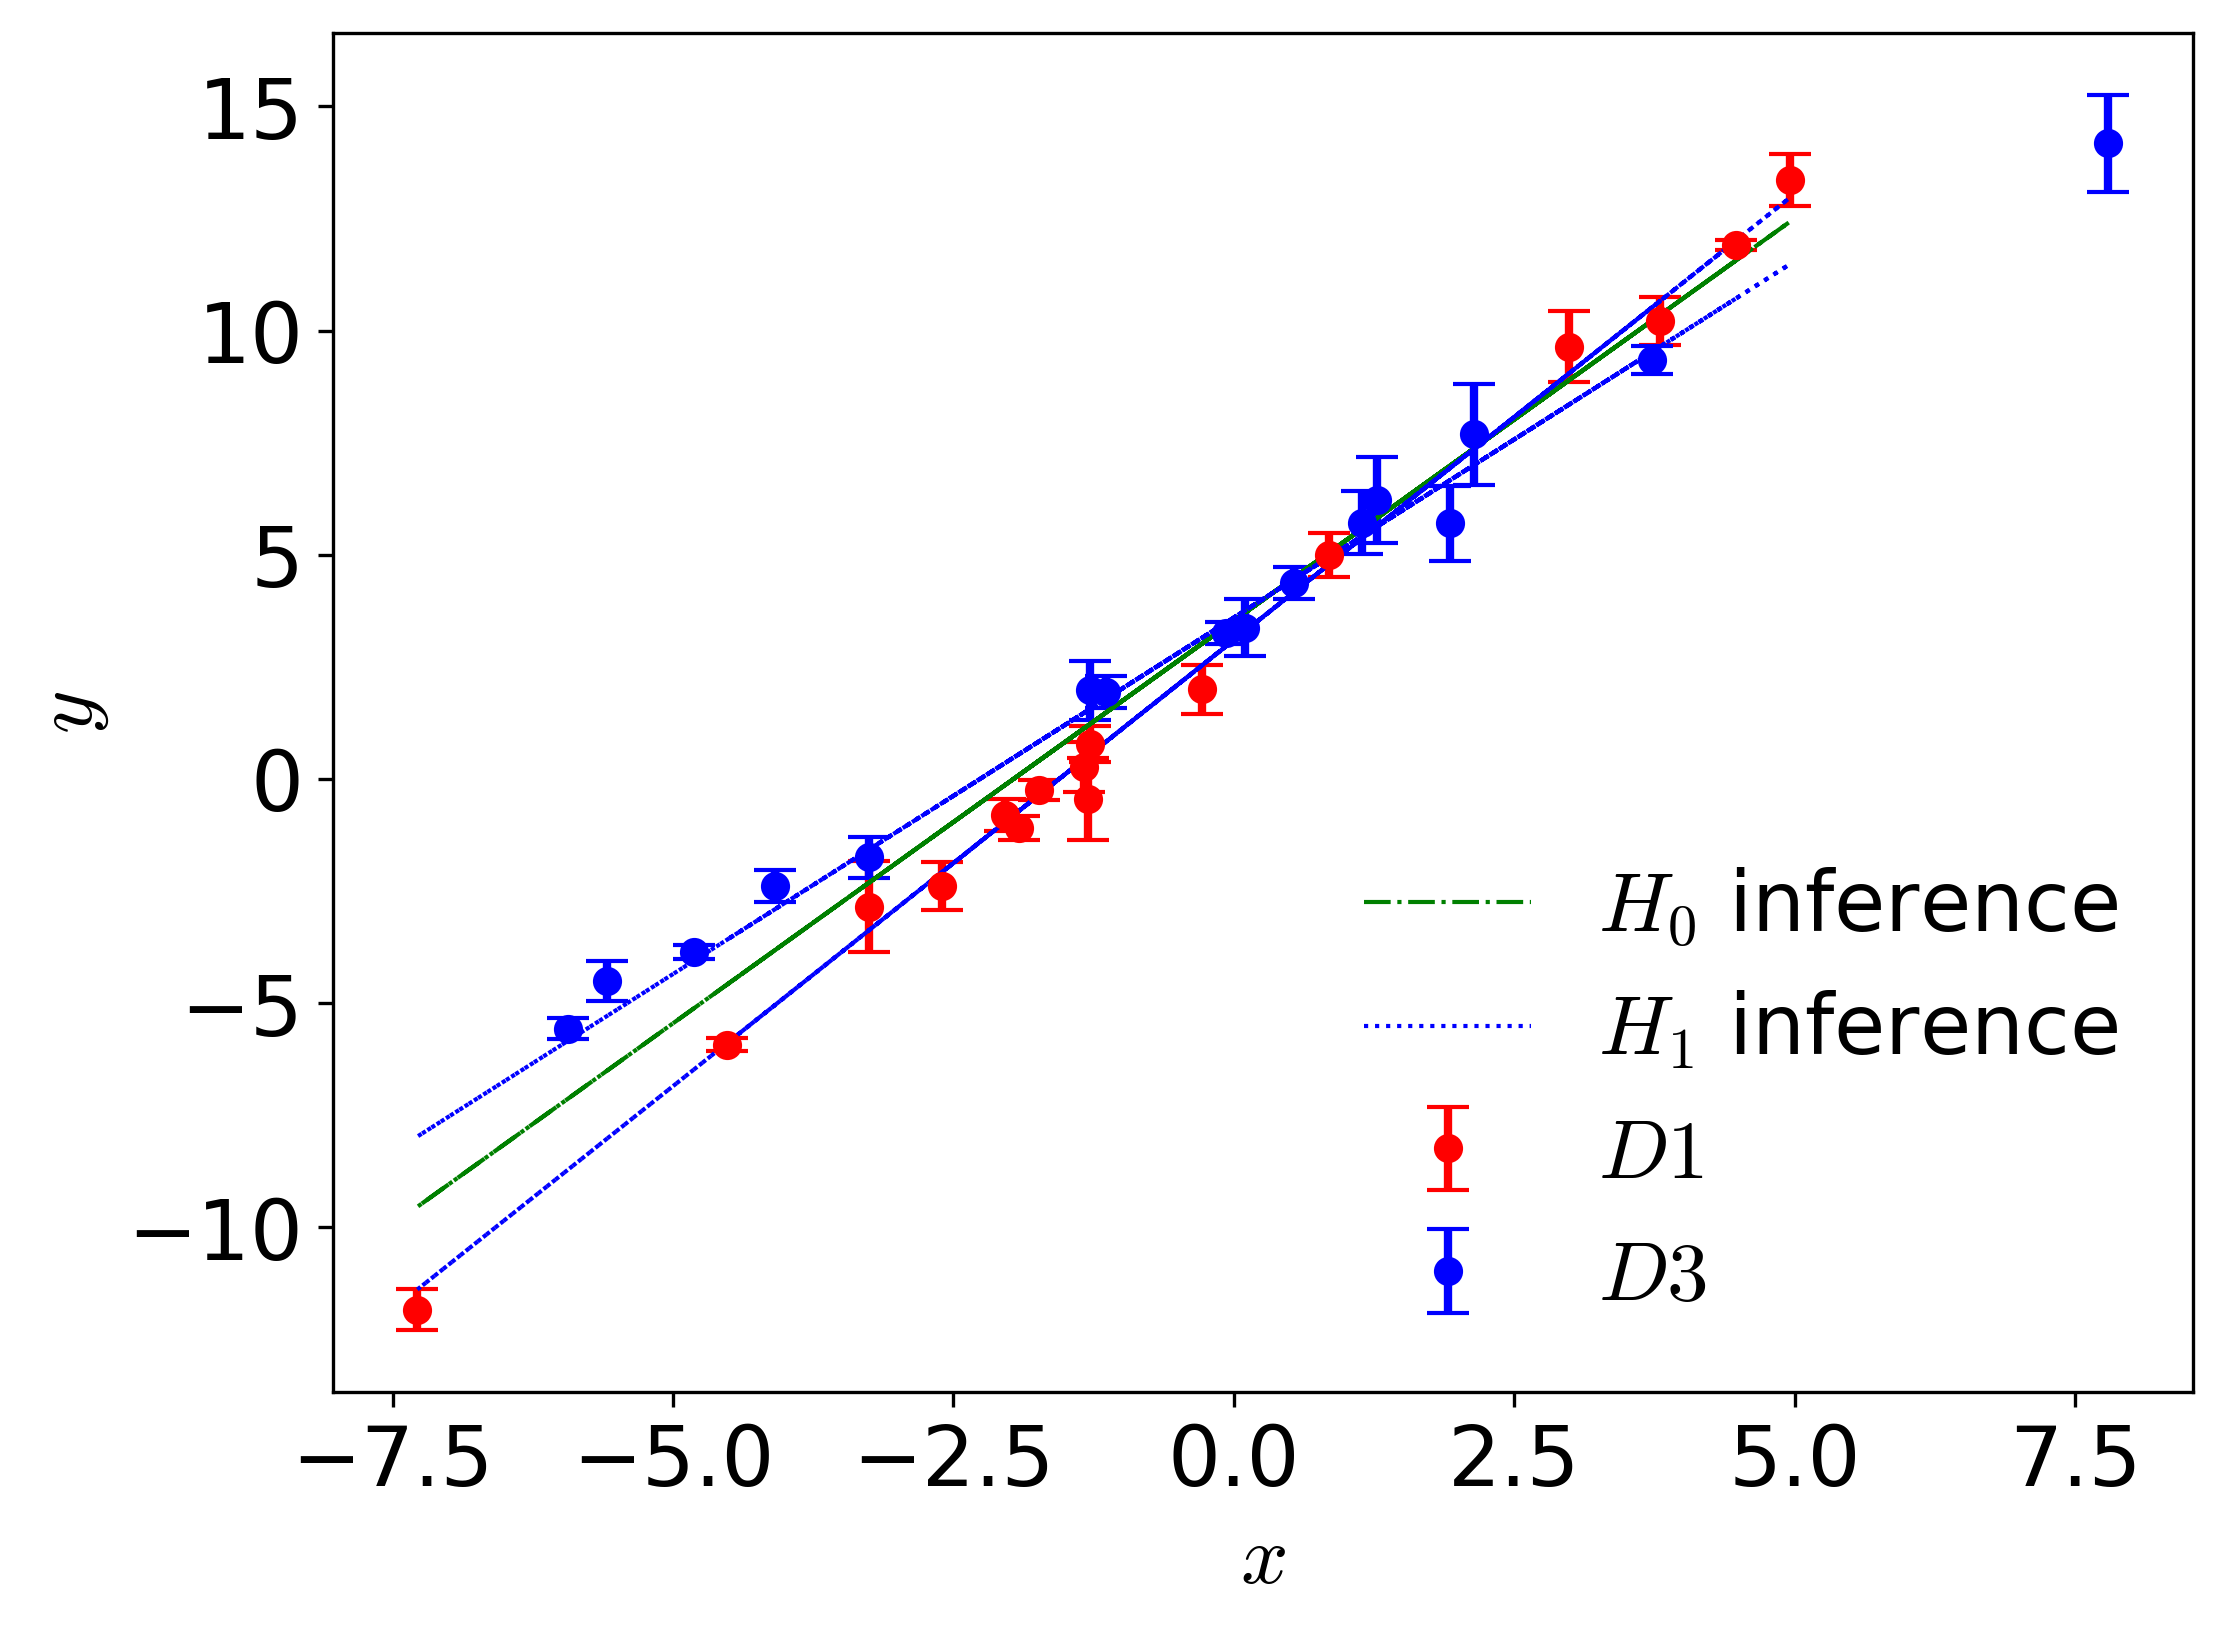

In [50]:
figsize = (8, 6)                        # definimos el tamaño de nuestra figura
dpi = 300                                # dots per inch

rcParams['font.size'] = 20          # establecemos el tamaño de la fuente
rcParams['lines.linewidth'] = 1          # el grosor de las líneas
rcParams['mathtext.fontset'] = 'cm'      # y el tipo de fuente en LaTex 

fig1 = figure(figsize=figsize, dpi=dpi)  # definimos la figura

 
plt.errorbar(x1, y1, y1_error,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='red', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$D1$')
plt.errorbar(x3, y3, y3_error,      #plt.errorbar(x, y, error_y)
             xerr=None, 
             color='blue', marker='o', ls='None', 
             elinewidth =2, capsize=5, capthick = 1, 
             label='$D3$')

plt.plot(x1,3.528359+1.795464*x1,label = '$H_0$ inference',color = 'green', linestyle='-.')
plt.plot(x1,3.1+1.99*x1,label = '$H_1$ inference',linestyle=':', color = 'blue')
plt.plot(x1,3.6+1.59*x1,linestyle=':', color = 'blue')

plt.legend(loc='best', frameon=False)     #pon la legenda donde mejor quede sin marco

xlabel(r'$x$')                            
ylabel(r'$y$') 